**TO GET THE IMAGES OF THE DATASET YOU MUST HAVE INTERNET CONNECTION IN YOUR KERNEL**

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['vehicle-number-plate-detection']


**GET COORD OF BOUNDING BOXES**

In [6]:
import json

# Read the data
data = pd.read_json('../input/vehicle-number-plate-detection/Indian_Number_plates.json', lines=True)


# Delete the empty column
del data['extras']

# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# And drop the rest of the annotation info
del data['annotation']

In [8]:
Images = []
Plates = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))

In [9]:
downloadTraining(data)

**CHECK OUR DATA**

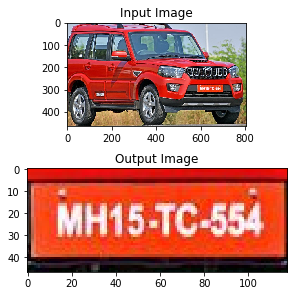

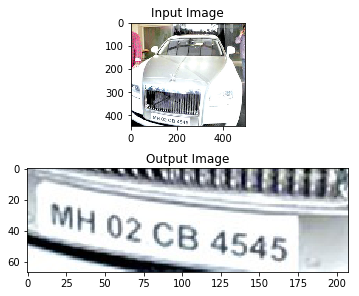

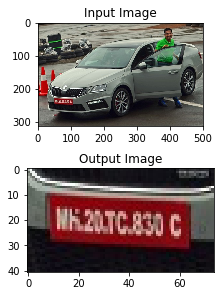

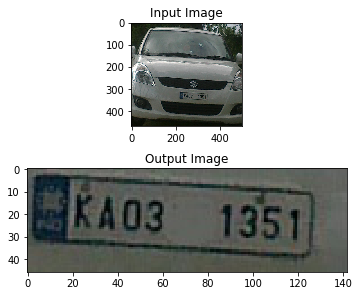

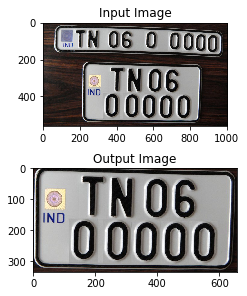

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
for i in range(len(Images[:5])):
    fig, ax = plt.subplots(2, 1, constrained_layout=True)

    # Set title
    ax[0].set_title('Input Image')
    ax[1].set_title('Output Image')

    # Display the images
    ax[0].imshow(Images[i])
    ax[1].imshow(Plates[i])

    plt.show()

In [11]:
import keras
from skimage.transform import rescale, resize
Images=np.array(Images)/255.
resimg=[0 for _ in range(len(Images))]
for i in range(len(Images)):
    resimg[i]=resize(Images[i],(96,96,3))
resimg=np.array(resimg)

Using TensorFlow backend.


In [12]:
Points=data['points']
resout=[0 for _ in range(len(Points))]
for i in range(len(Points)):
    resout[i]=[Points[i][0]['x'],Points[i][0]['y'],Points[i][1]['x'],Points[i][1]['y']]
resout=np.array(resout)
resout=resout.reshape(-1,4)

In [13]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [14]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
__________

In [26]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])
model.fit(resimg,resout,epochs = 30,batch_size = 50,validation_split = 0.2)

Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 15s 81ms/step - loss: 0.3785 - mean_absolute_error: 0.3621 - val_loss: 2.5228 - val_mean_absolute_error: 0.9528
Epoch 2/30
189/189 [==============================] - 13s 67ms/step - loss: 0.2130 - mean_absolute_error: 0.3411 - val_loss: 0.8823 - val_mean_absolute_error: 0.4541
Epoch 3/30
189/189 [==============================] - 13s 67ms/step - loss: 0.0887 - mean_absolute_error: 0.2247 - val_loss: 76.3450 - val_mean_absolute_error: 4.4921
Epoch 4/30
189/189 [==============================] - 13s 67ms/step - loss: 0.0612 - mean_absolute_error: 0.1932 - val_loss: 659.4575 - val_mean_absolute_error: 15.6473
Epoch 5/30
189/189 [==============================] - 13s 67ms/step - loss: 0.0526 - mean_absolute_error: 0.1775 - val_loss: 1836.5033 - val_mean_absolute_error: 27.0281
Epoch 6/30
189/189 [==============================] - 13s 67ms/step - loss: 0.0392 - mean_absolute_error: 0.1551 - va

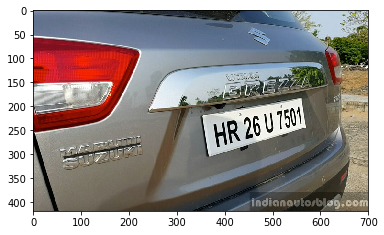

0.44508672 0.4854959 0.6926571 0.6045228 419 700
[0.50571429 0.45823389 0.83714286 0.68735084]


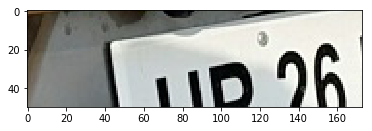

In [55]:
i=156
plt.imshow(Images[i])
plt.show()
width,height,o=Images[i].shape
p1,p2,p3,p4=model.predict(resimg[i].reshape(1,96,96,3))[0]
print(p1,p2,p3,p4,width,height)
left,right=int(height*p1),int(height*p3)
top,bottom=int(width*p2),int(p4*width)
print(resout[i])
resimg[4][left:right][top:bottom]
img1=plt.imshow(Images[i][top:bottom,left:right])
plt.show()

In [56]:
img1

In [ ]:
resimg[i,top:bottom,left:right]

In [ ]:
Images[0].shape

In [65]:
def main():

    blnKNNTrainingSuccessful = loadKNNDataAndTrainKNN()         # attempt KNN training

    if blnKNNTrainingSuccessful == False:                               # if KNN training was not successful
        print("\nerror: KNN traning was not successful\n")  # show error message
        return                                                          # and exit program
    # end if

    imgOriginalScene  = cv2.imread("img1")               # open image

    if imgOriginalScene is None:                            # if image was not read successfully
        print("\nerror: image not read from file \n\n")  # print error message to std out
        os.system("pause")                                  # pause so user can see error message
        return                                              # and exit program
    # end if

    listOfPossiblePlates = detectPlatesInScene(imgOriginalScene)           # detect plates

    listOfPossiblePlates = detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates

    cv2.imshow("imgOriginalScene", imgOriginalScene)            # show scene image

    if len(listOfPossiblePlates) == 0:                          # if no plates were found
        print("\nno license plates were detected\n")  # inform user no plates were found
    else:                                                       # else
                # if we get in here list of possible plates has at leat one plate

                # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
        listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

                # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
        licPlate = listOfPossiblePlates[0]

        cv2.imshow("imgPlate", licPlate.imgPlate)           # show crop of plate and threshold of plate
        cv2.imshow("imgThresh", licPlate.imgThresh)

        if len(licPlate.strChars) == 0:                     # if no chars were found in the plate
            print("\nno characters were detected\n\n")  # show message
            return                                          # and exit program
        # end if

        drawRedRectangleAroundPlate(imgOriginalScene, licPlate)             # draw red rectangle around plate

        print("\nlicense plate read from image = " + licPlate.strChars + "\n")  # write license plate text to std out
        print("----------------------------------------")

        writeLicensePlateCharsOnImage(imgOriginalScene, licPlate)           # write license plate text on the image

        cv2.imshow("imgOriginalScene", imgOriginalScene)                # re-show scene image

        cv2.imwrite("imgOriginalScene.png", imgOriginalScene)           # write image out to file

    # end if else

    cv2.waitKey(0)					# hold windows open until user presses a key

In [57]:
def drawRedRectangleAroundPlate(imgOriginalScene, licPlate):

    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)            # get 4 vertices of rotated rect

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)         # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)

In [63]:
def writeLicensePlateCharsOnImage(imgOriginalScene, licPlate):
    ptCenterOfTextAreaX = 0                             # this will be the center of the area the text will be written to
    ptCenterOfTextAreaY = 0

    ptLowerLeftTextOriginX = 0                          # this will be the bottom left of the area that the text will be written to
    ptLowerLeftTextOriginY = 0

    sceneHeight, sceneWidth, sceneNumChannels = imgOriginalScene.shape
    plateHeight, plateWidth, plateNumChannels = licPlate.imgPlate.shape

    intFontFace = cv2.FONT_HERSHEY_SIMPLEX                      # choose a plain jane font
    fltFontScale = float(plateHeight) / 30.0                    # base font scale on height of plate area
    intFontThickness = int(round(fltFontScale * 1.5))           # base font thickness on font scale

    textSize, baseline = cv2.getTextSize(licPlate.strChars, intFontFace, fltFontScale, intFontThickness)        # call getTextSize

            # unpack roatated rect into center point, width and height, and angle
    ( (intPlateCenterX, intPlateCenterY), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg ) = licPlate.rrLocationOfPlateInScene

    intPlateCenterX = int(intPlateCenterX)              # make sure center is an integer
    intPlateCenterY = int(intPlateCenterY)

    ptCenterOfTextAreaX = int(intPlateCenterX)         # the horizontal location of the text area is the same as the plate

    if intPlateCenterY < (sceneHeight * 0.75):                                                  # if the license plate is in the upper 3/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) + int(round(plateHeight * 1.6))      # write the chars in below the plate
    else:                                                                                       # else if the license plate is in the lower 1/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) - int(round(plateHeight * 1.6))      # write the chars in above the plate
    # end if

    textSizeWidth, textSizeHeight = textSize                # unpack text size width and height

    ptLowerLeftTextOriginX = int(ptCenterOfTextAreaX - (textSizeWidth / 2))           # calculate the lower left origin of the text area
    ptLowerLeftTextOriginY = int(ptCenterOfTextAreaY + (textSizeHeight / 2))          # based on the text area center, width, and height

            # write the text on the image
    cv2.putText(imgOriginalScene, licPlate.strChars, (ptLowerLeftTextOriginX, ptLowerLeftTextOriginY), intFontFace, fltFontScale, SCALAR_YELLOW, intFontThickness)
# end function


In [66]:
if __name__ == "__main__":
    main()


error, unable to open classifications.txt, exiting program


error: KNN traning was not successful



In [43]:
kNearest = cv2.ml.KNearest_create()

        # constants for checkIfPossibleChar, this checks one possible char only (does not compare to another char)
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8

MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0

MIN_PIXEL_AREA = 80

        # constants for comparing two chars
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0

MAX_CHANGE_IN_AREA = 0.5

MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2

MAX_ANGLE_BETWEEN_CHARS = 12.0

        # other constants
MIN_NUMBER_OF_MATCHING_CHARS = 3

RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30

MIN_CONTOUR_AREA = 100

In [44]:
def loadKNNDataAndTrainKNN():
    allContoursWithData = []                # declare empty lists,
    validContoursWithData = []              # we will fill these shortly

    try:
        npaClassifications = np.loadtxt("classifications.txt", np.float32)                  # read in training classifications
    except:                                                                                 # if file could not be opened
        print("error, unable to open classifications.txt, exiting program\n")  # show error message
        os.system("pause")
        return False                                                                        # and return False
    # end try

    try:
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)                 # read in training images
    except:                                                                                 # if file could not be opened
        print("error, unable to open flattened_images.txt, exiting program\n")  # show error message
        os.system("pause")
        return False                                                                        # and return False
    # end try

    npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))       # reshape numpy array to 1d, necessary to pass to call to train

    kNearest.setDefaultK(1)                                                             # set default K to 1

    kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)           # train KNN object

    return True           

In [45]:
def detectCharsInPlates(listOfPossiblePlates):
    intPlateCounter = 0
    imgContours = None
    contours = []

    if len(listOfPossiblePlates) == 0:          # if list of possible plates is empty
        return listOfPossiblePlates             # return
    # end if

            # at this point we can be sure the list of possible plates has at least one plate

    for possiblePlate in listOfPossiblePlates:          # for each possible plate, this is a big for loop that takes up most of the function

        possiblePlate.imgGrayscale, possiblePlate.imgThresh = Preprocess.preprocess(possiblePlate.imgPlate)     # preprocess to get grayscale and threshold images

        if Main.showSteps == True: # show steps ###################################################
            cv2.imshow("5a", possiblePlate.imgPlate)
            cv2.imshow("5b", possiblePlate.imgGrayscale)
            cv2.imshow("5c", possiblePlate.imgThresh)
        # end if # show steps #####################################################################

                # increase size of plate image for easier viewing and char detection
        possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx = 1.6, fy = 1.6)

                # threshold again to eliminate any gray areas
        thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if Main.showSteps == True: # show steps ###################################################
            cv2.imshow("5d", possiblePlate.imgThresh)
        # end if # show steps #####################################################################

                # find all possible chars in the plate,
                # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
        listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)

        if Main.showSteps == True: # show steps ###################################################
            height, width, numChannels = possiblePlate.imgPlate.shape
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]                                         # clear the contours list

            for possibleChar in listOfPossibleCharsInPlate:
                contours.append(possibleChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, Main.SCALAR_WHITE)

            cv2.imshow("6", imgContours)
        # end if # show steps #####################################################################

                # given a list of all possible chars, find groups of matching chars within the plate
        listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)

        if Main.showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for
                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            cv2.imshow("7", imgContours)
        # end if # show steps #####################################################################

        if (len(listOfListsOfMatchingCharsInPlate) == 0):			# if no groups of matching chars were found in the plate

            if Main.showSteps == True: # show steps ###############################################
                print("chars found in plate number " + str(
                    intPlateCounter) + " = (none), click on any image and press a key to continue . . .")
                intPlateCounter = intPlateCounter + 1
                cv2.destroyWindow("8")
                cv2.destroyWindow("9")
                cv2.destroyWindow("10")
                cv2.waitKey(0)
            # end if # show steps #################################################################

            possiblePlate.strChars = ""
            continue						# go back to top of for loop
        # end if

        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):                              # within each list of matching chars
            listOfListsOfMatchingCharsInPlate[i].sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right
            listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])              # and remove inner overlapping chars
        # end for

        if Main.showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                del contours[:]

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for

                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            cv2.imshow("8", imgContours)
        # end if # show steps #####################################################################

                # within each possible plate, suppose the longest list of potential matching chars is the actual list of chars
        intLenOfLongestListOfChars = 0
        intIndexOfLongestListOfChars = 0

                # loop through all the vectors of matching chars, get the index of the one with the most chars
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
                intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
                intIndexOfLongestListOfChars = i
            # end if
        # end for

                # suppose that the longest list of matching chars within the plate is the actual list of chars
        longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]

        if Main.showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for matchingChar in longestListOfMatchingCharsInPlate:
                contours.append(matchingChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, Main.SCALAR_WHITE)

            cv2.imshow("9", imgContours)
        # end if # show steps #####################################################################

        possiblePlate.strChars = recognizeCharsInPlate(possiblePlate.imgThresh, longestListOfMatchingCharsInPlate)

        if Main.showSteps == True: # show steps ###################################################
            print("chars found in plate number " + str(
                intPlateCounter) + " = " + possiblePlate.strChars + ", click on any image and press a key to continue . . .")
            intPlateCounter = intPlateCounter + 1
            cv2.waitKey(0)
        # end if # show steps #####################################################################

    # end of big for loop that takes up most of the function

    if Main.showSteps == True:
        print("\nchar detection complete, click on any image and press a key to continue . . .\n")
        cv2.waitKey(0)
    # end if

    return listOfPossiblePlates

In [46]:
def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = []                        # this will be the return value
    contours = []
    imgThreshCopy = imgThresh.copy()

            # find all contours in plate
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:                        # for each contour
        possibleChar = PossibleChar.PossibleChar(contour)

        if checkIfPossibleChar(possibleChar):              # if contour is a possible char, note this does not compare to other chars (yet) . . .
            listOfPossibleChars.append(possibleChar)       # add to list of possible chars
        # end if
    # end if

    return listOfPossibleChars
# end function

In [47]:
def checkIfPossibleChar(possibleChar):
            # this function is a 'first pass' that does a rough check on a contour to see if it could be a char,
            # note that we are not (yet) comparing the char to other chars to look for a group
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
        possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
        MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False
    # end if
# end function

In [48]:
def findListOfListsOfMatchingChars(listOfPossibleChars):
            # with this function, we start off with all the possible chars in one big list
            # the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
            # note that chars that are not found to be in a group of matches do not need to be considered further
    listOfListsOfMatchingChars = []                  # this will be the return value

    for possibleChar in listOfPossibleChars:                        # for each possible char in the one big list of chars
        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)        # find all chars in the big list that match the current char

        listOfMatchingChars.append(possibleChar)                # also add the current char to current possible list of matching chars

        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:     # if current possible list of matching chars is not long enough to constitute a possible plate
            continue                            # jump back to the top of the for loop and try again with next char, note that it's not necessary
                                                # to save the list in any way since it did not have enough chars to be a possible plate
        # end if

                                                # if we get here, the current list passed test as a "group" or "cluster" of matching chars
        listOfListsOfMatchingChars.append(listOfMatchingChars)      # so add to our list of lists of matching chars

        listOfPossibleCharsWithCurrentMatchesRemoved = []

                                                # remove the current list of matching chars from the big list so we don't use those same chars twice,
                                                # make sure to make a new big list for this since we don't want to change the original big list
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))

        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)      # recursive call

        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:        # for each list of matching chars found by recursive call
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)             # add to our original list of lists of matching chars
        # end for

        break       # exit for

    # end for

    return listOfListsOfMatchingChars
# end function

In [49]:
def findListOfMatchingChars(possibleChar, listOfChars):
            # the purpose of this function is, given a possible char and a big list of possible chars,
            # find all chars in the big list that are a match for the single possible char, and return those matching chars as a list
    listOfMatchingChars = []                # this will be the return value

    for possibleMatchingChar in listOfChars:                # for each char in big list
        if possibleMatchingChar == possibleChar:    # if the char we attempting to find matches for is the exact same char as the char in the big list we are currently checking
                                                    # then we should not include it in the list of matches b/c that would end up double including the current char
            continue                                # so do not add to list of matches and jump back to top of for loop
        # end if
                    # compute stuff to see if chars are a match
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)

        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)

        fltChangeInArea = float(abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(possibleChar.intBoundingRectArea)

        fltChangeInWidth = float(abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(possibleChar.intBoundingRectHeight)

                # check if chars match
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
            fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
            fltChangeInArea < MAX_CHANGE_IN_AREA and
            fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
            fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):

            listOfMatchingChars.append(possibleMatchingChar)        # if the chars are a match, add the current char to list of matching chars
        # end if
    # end for

    return listOfMatchingChars     

In [50]:
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)

    return math.sqrt((intX ** 2) + (intY ** 2))
# end function

In [51]:
def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))

    if fltAdj != 0.0:                           # check to make sure we do not divide by zero if the center X positions are equal, float division by zero will cause a crash in Python
        fltAngleInRad = math.atan(fltOpp / fltAdj)      # if adjacent is not zero, calculate angle
    else:
        fltAngleInRad = 1.5708                          # if adjacent is zero, use this as the angle, this is to be consistent with the C++ version of this program
    # end if

    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)       # calculate angle in degrees

    return fltAngleInDeg
# end function

In [52]:
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)                # this will be the return value

    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:        # if current char and other char are not the same char . . .
                                                                            # if current char and other char have center points at almost the same location . . .
                if distanceBetweenChars(currentChar, otherChar) < (currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                                # if we get in here we have found overlapping chars
                                # next we identify which char is smaller, then if that char was not already removed on a previous pass, remove it
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:         # if current char is smaller than other char
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:              # if current char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)         # then remove current char
                        # end if
                    else:                                                                       # else if other char is smaller than current char
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:                # if other char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)           # then remove other char
                        # end if
                    # end if
                # end if
            # end if
        # end for
    # end for

    return listOfMatchingCharsWithInnerCharRemoved
# end function

In [53]:
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""               # this will be the return value, the chars in the lic plate

    height, width = imgThresh.shape

    imgThreshColor = np.zeros((height, width, 3), np.uint8)

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right

    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)                     # make color version of threshold image so we can draw contours in color on it

    for currentChar in listOfMatchingChars:                                         # for each char in plate
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth), (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))

        cv2.rectangle(imgThreshColor, pt1, pt2, Main.SCALAR_GREEN, 2)           # draw green box around the char

                # crop char out of threshold image
        imgROI = imgThresh[currentChar.intBoundingRectY : currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,
                           currentChar.intBoundingRectX : currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]

        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT))           # resize image, this is necessary for char recognition

        npaROIResized = imgROIResized.reshape((1, RESIZED_CHAR_IMAGE_WIDTH * RESIZED_CHAR_IMAGE_HEIGHT))        # flatten image into 1d numpy array

        npaROIResized = np.float32(npaROIResized)               # convert from 1d numpy array of ints to 1d numpy array of floats

        retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)              # finally we can call findNearest !!!

        strCurrentChar = str(chr(int(npaResults[0][0])))            # get character from results

        strChars = strChars + strCurrentChar                        # append current char to full string

    # end for

    if Main.showSteps == True: # show steps #######################################################
        cv2.imshow("10", imgThreshColor)
    # end if # show steps #########################################################################

    return strChars
# end function

In [54]:
class PossibleChar:

    # constructor #################################################################################
    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour)

        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)
    # end constructor

In [34]:
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

In [35]:
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)

    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)

    height, width = imgGrayscale.shape

    imgBlurred = np.zeros((height, width, 1), np.uint8)

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)

    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh
# end function

In [36]:
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)

    return imgValue

In [37]:
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

In [38]:
class PossiblePlate:

    # constructor #################################################################################
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None

        self.rrLocationOfPlateInScene = None

        self.strChars = ""
    # end constructor

# end class

In [39]:
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5
def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = PossiblePlate.PossiblePlate()           # this will be the return value

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right based on x position

            # calculate the center point of the plate
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY) / 2.0

    ptPlateCenter = fltPlateCenterX, fltPlateCenterY

            # calculate plate width and height
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)

    intTotalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight
    # end for

    fltAverageCharHeight = intTotalOfCharHeights / len(listOfMatchingChars)

    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR)

            # calculate correction angle of plate region
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = DetectChars.distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)

            # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = ( tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg )

            # final steps are to perform the actual rotation

            # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg, 1.0)

    height, width, numChannels = imgOriginal.shape      # unpack original image width and height

    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))       # rotate the entire image

    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight), tuple(ptPlateCenter))

    possiblePlate.imgPlate = imgCropped         # copy the cropped plate image into the applicable member variable of the possible plate

    return possiblePlate
# end function














In [40]:
def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []                   # this will be the return value

    height, width, numChannels = imgOriginalScene.shape

    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)

    cv2.destroyAllWindows()

    if Main.showSteps == True: # show steps #######################################################
        cv2.imshow("0", imgOriginalScene)
    # end if # show steps #########################################################################

    imgGrayscaleScene, imgThreshScene = Preprocess.preprocess(imgOriginalScene)         # preprocess to get grayscale and threshold images

    if Main.showSteps == True: # show steps #######################################################
        cv2.imshow("1a", imgGrayscaleScene)
        cv2.imshow("1b", imgThreshScene)
    # end if # show steps #########################################################################

            # find all possible chars in the scene,
            # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
    listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene)

    if Main.showSteps == True: # show steps #######################################################
        print("step 2 - len(listOfPossibleCharsInScene) = " + str(
            len(listOfPossibleCharsInScene)))  # 131 with MCLRNF1 image

        imgContours = np.zeros((height, width, 3), np.uint8)

        contours = []

        for possibleChar in listOfPossibleCharsInScene:
            contours.append(possibleChar.contour)
        # end for

        cv2.drawContours(imgContours, contours, -1, Main.SCALAR_WHITE)
        cv2.imshow("2b", imgContours)
    # end if # show steps #########################################################################

            # given a list of all possible chars, find groups of matching chars
            # in the next steps each group of matching chars will attempt to be recognized as a plate
    listOfListsOfMatchingCharsInScene = DetectChars.findListOfListsOfMatchingChars(listOfPossibleCharsInScene)

    if Main.showSteps == True: # show steps #######################################################
        print("step 3 - listOfListsOfMatchingCharsInScene.Count = " + str(
            len(listOfListsOfMatchingCharsInScene)))  # 13 with MCLRNF1 image

        imgContours = np.zeros((height, width, 3), np.uint8)

        for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
            intRandomBlue = random.randint(0, 255)
            intRandomGreen = random.randint(0, 255)
            intRandomRed = random.randint(0, 255)

            contours = []

            for matchingChar in listOfMatchingChars:
                contours.append(matchingChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
        # end for

        cv2.imshow("3", imgContours)
    # end if # show steps #########################################################################

    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:                   # for each group of matching chars
        possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)         # attempt to extract plate

        if possiblePlate.imgPlate is not None:                          # if plate was found
            listOfPossiblePlates.append(possiblePlate)                  # add to list of possible plates
        # end if
    # end for

    print("\n" + str(len(listOfPossiblePlates)) + " possible plates found")  # 13 with MCLRNF1 image

    if Main.showSteps == True: # show steps #######################################################
        print("\n")
        cv2.imshow("4a", imgContours)

        for i in range(0, len(listOfPossiblePlates)):
            p2fRectPoints = cv2.boxPoints(listOfPossiblePlates[i].rrLocationOfPlateInScene)

            cv2.line(imgContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), Main.SCALAR_RED, 2)

            cv2.imshow("4a", imgContours)

            print("possible plate " + str(i) + ", click on any image and press a key to continue . . .")

            cv2.imshow("4b", listOfPossiblePlates[i].imgPlate)
            cv2.waitKey(0)
        # end for

        print("\nplate detection complete, click on any image and press a key to begin char recognition . . .\n")
        cv2.waitKey(0)
    # end if # show steps #########################################################################

    return listOfPossiblePlates
# end function

In [41]:
def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []                # this will be the return value

    intCountOfPossibleChars = 0

    imgThreshCopy = imgThresh.copy()

    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)   # find all contours

    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)

    for i in range(0, len(contours)):                       # for each contour

        if Main.showSteps == True: # show steps ###################################################
            cv2.drawContours(imgContours, contours, i, Main.SCALAR_WHITE)
        # end if # show steps #####################################################################

        possibleChar = PossibleChar.PossibleChar(contours[i])

        if DetectChars.checkIfPossibleChar(possibleChar):                   # if contour is a possible char, note this does not compare to other chars (yet) . . .
            intCountOfPossibleChars = intCountOfPossibleChars + 1           # increment count of possible chars
            listOfPossibleChars.append(possibleChar)                        # and add to list of possible chars
        # end if
    # end for

    if Main.showSteps == True: # show steps #######################################################
        print("\nstep 2 - len(contours) = " + str(len(contours)))  # 2362 with MCLRNF1 image
        print("step 2 - intCountOfPossibleChars = " + str(intCountOfPossibleChars))  # 131 with MCLRNF1 image
        cv2.imshow("2a", imgContours)
    # end if # show steps #################
    return listOfPossibleChars
# end function